# Examples from extracting ocean currents from a model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import cmocean
import xarray as xa
import scipy.ndimage as nd
import cartopy.crs as ccrs
import cartopy.feature as cfeature


import sys,os
testdir = os.path.dirname(os.getcwd() + '/')
srcdir = '..'
sys.path.insert(0, os.path.abspath(os.path.join(testdir, srcdir)))
sys.path.insert(1, '/Users/tpvan/Waves/ocean_wave_tracing')

from ocean_wave_tracing import Wave_tracing

%matplotlib inline

In [3]:
# READ ROMS DATA

fname = 'https://thredds.met.no/thredds/dodsC/sea/norkyst800m/1h/aggregate_be'
da = xa.open_dataset(fname)

da.head()

<xarray.Dataset> Size: 24kB
Dimensions:                  (s_rho: 5, s_w: 5, X: 5, Y: 5, depth: 5, time: 5)
Coordinates:
  * X                        (X) float64 40B 0.0 800.0 1.6e+03 2.4e+03 3.2e+03
  * Y                        (Y) float64 40B 0.0 800.0 1.6e+03 2.4e+03 3.2e+03
  * depth                    (depth) float64 40B 0.0 3.0 10.0 15.0 25.0
  * time                     (time) datetime64[ns] 40B 2017-02-20 ... 2017-02...
    lat                      (Y, X) float64 200B ...
    lon                      (Y, X) float64 200B ...
Dimensions without coordinates: s_rho, s_w
Data variables: (12/20)
    Cs_r                     (s_rho) float64 40B ...
    Cs_w                     (s_w) float64 40B ...
    forecast_reference_time  datetime64[ns] 8B ...
    hc                       float64 8B ...
    projection_stere         int32 4B ...
    angle                    (Y, X) float64 200B ...
    ...                       ...
    ubar                     (time, Y, X) float32 500B ...
    v                        (time, depth, Y, X) float32 2kB ...
    v_northward              (time, depth, Y, X) float32 2kB ...
    vbar                     (time, Y, X) float32 500B ...
    w                        (time, depth, Y, X) float32 2kB ...
    zeta                     (time, Y, X) float32 500B ...
Attributes: (12/59)
    file:                   /home/metno_op/run/norkyst-800m_2017/ocean_his.nc
    type:                   ROMS/TOMS history file
    title:                  NorKyst-800m - ROMS
    var_info:               /home/metno_op/sea/ROMS/metroms_apps/norkyst-800m...
    rst_file:               /home/metno_op/run/norkyst-800m_2017/ocean_rst.nc
    his_file:               /home/metno_op/run/norkyst-800m_2017/ocean_his.nc
    ...                     ...
    publisher_name:         Norwegian Meteorological Institute / Arctic Data ...
    publisher_institution:  Norwegian Meteorological Institute
    publisher_email:        adc-support@met.no
    publisher_url:          https://adc.met.no/
    project:                Ocean and Ice - Research to Operation (HI-R2O)
    license:                https://spdx.org/licenses/CC-BY-4.0.html (CC-BY-4.0)

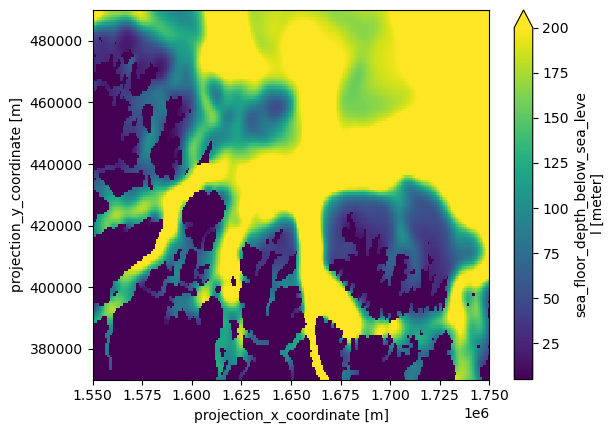

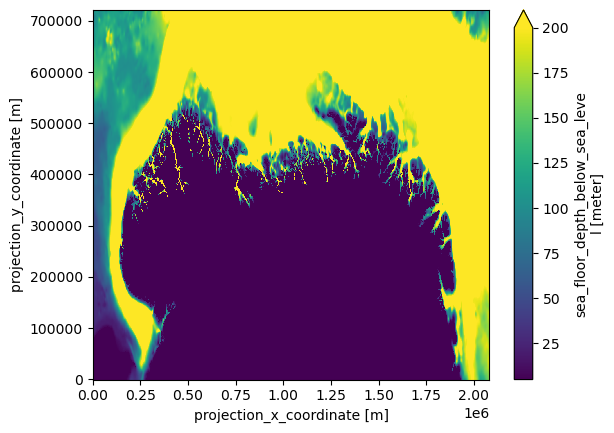

In [68]:
# Subset the dataset
t0, t1 = "2019-01-24T09", "2019-01-24T12"
step = 1
X0, XN = 1.55e6, 1.75e6
Y0, YN = 3.7e5 , 4.9e5
ocn_subset=da.loc[dict(time=slice(np.datetime64(t0),np.datetime64(t1)),
                X=slice(X0,XN,step),Y=slice(Y0,YN,step))]
                    # X=slice(1.45e6,1.6e6,step),Y=slice(4.3e5,6e5,step))]
ocn_subset.h.plot.pcolormesh(vmax=200)
plt.figure()
da.h.plot.pcolormesh(vmax=200)

(array([   486.,   1303.,   2951.,   9957., 114761., 194841.,  36218.,
          8773.,   3440.,   1027.]),
 array([-1.36705625, -1.09307122, -0.81908631, -0.54510128, -0.27111632,
         0.00286865,  0.27685362,  0.55083859,  0.82482362,  1.09880853,
         1.37279356]),
 <BarContainer object of 10 artists>)

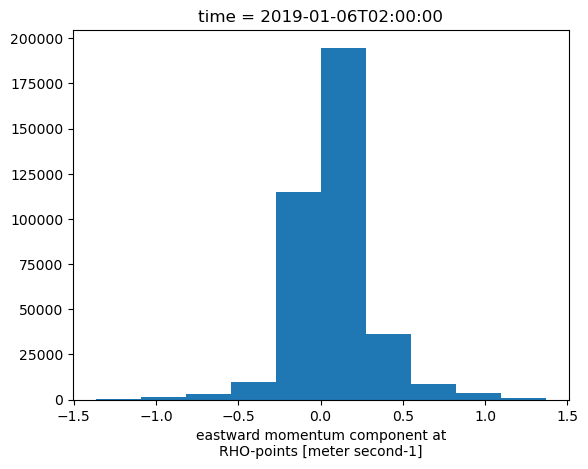

In [52]:
# Subset the dataset
t0, t1 = "2019-01-06T01","2019-01-24T11"
step = 1
X0, XN = 1.55e6, 1.75e6
Y0, YN = 3.7e5 , 4.9e5

bbox_idx = slice(1420,1600,1) #latitude MOSKEN
bbox_idy = slice(610,680,1) #longitude MOSKEN




# ocn_subset_mosken=da.isel(X=bbox_idx,Y=bbox_idy).sel(time=["2019-01-06T01","2019-01-24T11"],
#                                                      depth=0,s_rho=0,s_w=0)
#                     #X=slice(1.45e6,1.6e6,step),Y=slice(4.3e5,6e5,step))]

ocn_subset_mosken=da.loc[dict(time=slice(np.datetime64(t0),np.datetime64(t1)),
                # X=bbox_idx,Y=bbox_idy)]
                X=slice(1.45e6,1.6e6,step),Y=slice(4.3e5,6e5,step))]

ocn_subset_mosken.u_eastward.isel(time=1).plot() #.plot.pcolormesh(vmax=200)

In [53]:
# SET conditions for wave tracing
nb_wave_rays = 50#200#550#nx
T = 4*3600
nt = 1000
wave_period = 10
i_w_side = 'top'
theta0=1.5*np.pi#0


In [54]:
ocn_subset_mosken

<xarray.Dataset> Size: 9GB
Dimensions:                  (s_rho: 35, s_w: 36, X: 188, Y: 213, depth: 16,
                              time: 443)
Coordinates:
  * X                        (X) float64 2kB 1.45e+06 1.451e+06 ... 1.6e+06
  * Y                        (Y) float64 2kB 4.304e+05 4.312e+05 ... 6e+05
  * depth                    (depth) float64 128B 0.0 3.0 10.0 ... 2e+03 3e+03
  * time                     (time) datetime64[ns] 4kB 2019-01-06T01:00:00 .....
    lat                      (Y, X) float64 320kB ...
    lon                      (Y, X) float64 320kB ...
Dimensions without coordinates: s_rho, s_w
Data variables: (12/20)
    Cs_r                     (s_rho) float64 280B ...
    Cs_w                     (s_w) float64 288B ...
    forecast_reference_time  datetime64[ns] 8B ...
    hc                       float64 8B ...
    projection_stere         int32 4B ...
    angle                    (Y, X) float64 320kB ...
    ...                       ...
    ubar                     (time, Y, X) float32 71MB ...
    v                        (time, depth, Y, X) float32 1GB ...
    v_northward              (time, depth, Y, X) float32 1GB ...
    vbar                     (time, Y, X) float32 71MB ...
    w                        (time, depth, Y, X) float32 1GB ...
    zeta                     (time, Y, X) float32 71MB ...
Attributes: (12/59)
    file:                   /home/metno_op/run/norkyst-800m_2017/ocean_his.nc
    type:                   ROMS/TOMS history file
    title:                  NorKyst-800m - ROMS
    var_info:               /home/metno_op/sea/ROMS/metroms_apps/norkyst-800m...
    rst_file:               /home/metno_op/run/norkyst-800m_2017/ocean_rst.nc
    his_file:               /home/metno_op/run/norkyst-800m_2017/ocean_his.nc
    ...                     ...
    publisher_name:         Norwegian Meteorological Institute / Arctic Data ...
    publisher_institution:  Norwegian Meteorological Institute
    publisher_email:        adc-support@met.no
    publisher_url:          https://adc.met.no/
    project:                Ocean and Ice - Research to Operation (HI-R2O)
    license:                https://spdx.org/licenses/CC-BY-4.0.html (CC-BY-4.0)

In [55]:
wt_ocn = Wave_tracing(U=ocn_subset.u_eastward.sel(depth=0).rename({'X':'x','Y':'y'}),
                      V=ocn_subset.v_northward.sel(depth=0).rename({'X':'x','Y':'y'}), 
                      nx=ocn_subset.sizes['X'], ny=ocn_subset.sizes['Y'],
                      nt=nt,T=T,
                      dx=ocn_subset.X.diff(dim='X')[0].values,
                      dy=ocn_subset.Y.diff(dim='Y')[0].values, 
                      nb_wave_rays=nb_wave_rays,
                      domain_X0=ocn_subset.X.min().values, domain_XN=ocn_subset.X.max().values,
                      domain_Y0=ocn_subset.Y.min().values, domain_YN=ocn_subset.Y.max().values,                       
                      temporal_evolution=True, d=ocn_subset.h.values,
                      DEBUG=False)
wt_ocn.set_initial_condition(wave_period=wave_period, theta0=theta0,incoming_wave_side=i_w_side)
wt_ocn.solve()

In [56]:
wt_zero = Wave_tracing(U=ocn_subset.u_eastward.sel(depth=0).rename({'X':'x','Y':'y'})*0, 
                       V=ocn_subset.v_northward.sel(depth=0).rename({'X':'x','Y':'y'})*0, 
                      nx=ocn_subset.sizes['X'], ny=ocn_subset.sizes['Y'],
                      nt=nt,T=T,
                      dx=ocn_subset.X.diff(dim='X')[0].values,
                      dy=ocn_subset.Y.diff(dim='Y')[0].values, 
                      nb_wave_rays=nb_wave_rays,
                      domain_X0=ocn_subset.X.min().values, domain_XN=ocn_subset.X.max().values,
                      domain_Y0=ocn_subset.Y.min().values, domain_YN=ocn_subset.Y.max().values,                      
                      temporal_evolution=False, d=ocn_subset.h.values,
                      DEBUG=False)
wt_zero.set_initial_condition(wave_period=wave_period, theta0=theta0, incoming_wave_side=i_w_side)
wt_zero.solve()

In [57]:
wt_mosk_OT = Wave_tracing(U=ocn_subset_mosken.u_eastward.isel(time=0).rename({'X':'x','Y':'y'}), 
                          V=ocn_subset_mosken.v_northward.isel(time=0).rename({'X':'x','Y':'y'}), 
                          nx=ocn_subset_mosken.sizes['X'], ny=ocn_subset_mosken.sizes['Y'],
                          nt=400,T=1.2*3600,
                          dx=ocn_subset.X.diff(dim='X')[0].values,
                          dy=ocn_subset.Y.diff(dim='Y')[0].values, 
                          nb_wave_rays=nb_wave_rays,
                          domain_X0=ocn_subset_mosken.X.min().values, domain_XN=ocn_subset_mosken.X.max().values,
                          domain_Y0=ocn_subset_mosken.Y.min().values, domain_YN=ocn_subset_mosken.Y.max().values,                      
                          temporal_evolution=False, d=ocn_subset_mosken.h.values,
                      DEBUG=False)

ipx = np.linspace(1.21e6,1.24e6,nb_wave_rays)
ipy = np.ones(nb_wave_rays)*5.35e5

wt_mosk_OT.set_initial_condition(wave_period=13, theta0=-0.57*np.pi, ipx=ipx,ipy=ipy)
wt_mosk_OT.solve()

ValueError: too many values to unpack (expected 2)

In [58]:
wt_mosk_IT = Wave_tracing(U=ocn_subset_mosken.u_eastward.isel(time=1).rename({'X':'x','Y':'y'}), 
                          V=ocn_subset_mosken.v_northward.isel(time=1).rename({'X':'x','Y':'y'}), 
                          nx=ocn_subset_mosken.sizes['X'], ny=ocn_subset_mosken.sizes['Y'],
                          nt=400,T=1.0*3600,
                          dx=ocn_subset.X.diff(dim='X')[0].values,
                          dy=ocn_subset.Y.diff(dim='Y')[0].values, 
                          nb_wave_rays=nb_wave_rays,
                          domain_X0=ocn_subset_mosken.X.min().values, domain_XN=ocn_subset_mosken.X.max().values,
                          domain_Y0=ocn_subset_mosken.Y.min().values, domain_YN=ocn_subset_mosken.Y.max().values,                      
                          temporal_evolution=False, d=ocn_subset_mosken.h.values,
                      DEBUG=False)


central_angle = -0.50*np.pi+np.pi
theta0_IT = np.linspace(central_angle-0.6,central_angle+0.6,nb_wave_rays)
ipx = np.ones(nb_wave_rays)*1.223e6
ipy = np.ones(nb_wave_rays)*5.01e5

wt_mosk_IT.set_initial_condition(wave_period=7, theta0=theta0_IT, ipx=ipx,ipy=ipy)
wt_mosk_IT.solve()

ValueError: too many values to unpack (expected 2)

## Transform to latlon and make xarray DataSet

In [59]:
proj_str = ocn_subset.projection_stere.proj4
ds_ocn = wt_ocn.to_ds(proj4=proj_str)
ds_zero = wt_zero.to_ds(proj4=proj_str)
ds_mosk_OT = wt_mosk_OT.to_ds(proj4=proj_str)
ds_mosk_IT = wt_mosk_IT.to_ds(proj4=proj_str)

In [60]:
speed_OT = np.sqrt(wt_mosk_OT.U[0,:,:]**2 + wt_mosk_OT.V[0,:,:]**2)
speed_IT = np.sqrt(wt_mosk_IT.U[0,:,:]**2 + wt_mosk_IT.V[0,:,:]**2)

In [61]:
fs = 18 #font size
crs_kws = dict(projection=ccrs.NorthPolarStereo(), facecolor="0.90")
data_crs = ccrs.PlateCarree()
geodetic = ccrs.Geodetic(globe=ccrs.Globe(datum='WGS84'))

#lscale='full'
lscale='intermediate'
f = cfeature.GSHHSFeature(scale=lscale, levels=[1],
        facecolor=cfeature.COLORS['land'])

# SET plot extent
lonmin, lonmax, latmin, latmax = -10,25,50,80#12.1+0.4, 13.2, 67.7-0.1, 68
plot_extent = [lonmin, lonmax, latmin, latmax ]

In [62]:
# Extrac subset model domain
subset_lon_extent = np.concatenate((ocn_subset.lon[:,-1], ocn_subset.lon[:,0], ocn_subset.lon[0,:], ocn_subset.lon[-1,:]))
subset_lat_extent = np.concatenate((ocn_subset.lat[:,-1], ocn_subset.lat[:,0], ocn_subset.lat[0,:], ocn_subset.lat[-1,:]))

subset_lon_extent_mosk = np.concatenate((ocn_subset_mosken.lon[:,-1], ocn_subset_mosken.lon[:,0], ocn_subset_mosken.lon[0,:], ocn_subset_mosken.lon[-1,:]))
subset_lat_extent_mosk = np.concatenate((ocn_subset_mosken.lat[:,-1], ocn_subset_mosken.lat[:,0], ocn_subset_mosken.lat[0,:], ocn_subset_mosken.lat[-1,:]))

## Plot

C:\Users\tpvan\miniforge3\envs\wave_tracing\Lib\site-packages\shapely\creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
C:\Users\tpvan\miniforge3\envs\wave_tracing\Lib\site-packages\shapely\creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
C:\Users\tpvan\miniforge3\envs\wave_tracing\Lib\site-packages\shapely\creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
C:\Users\tpvan\miniforge3\envs\wave_tracing\Lib\site-packages\shapely\creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
C:\Users\tpvan\miniforge3\envs\wave_tracing\Lib\site-packages\shapely\creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
C:\Users\tpvan\minif

TypeError: Dimensions of C (16, 213, 188) should be one smaller than X(188) and Y(213) while using shading='flat' see help(pcolormesh)

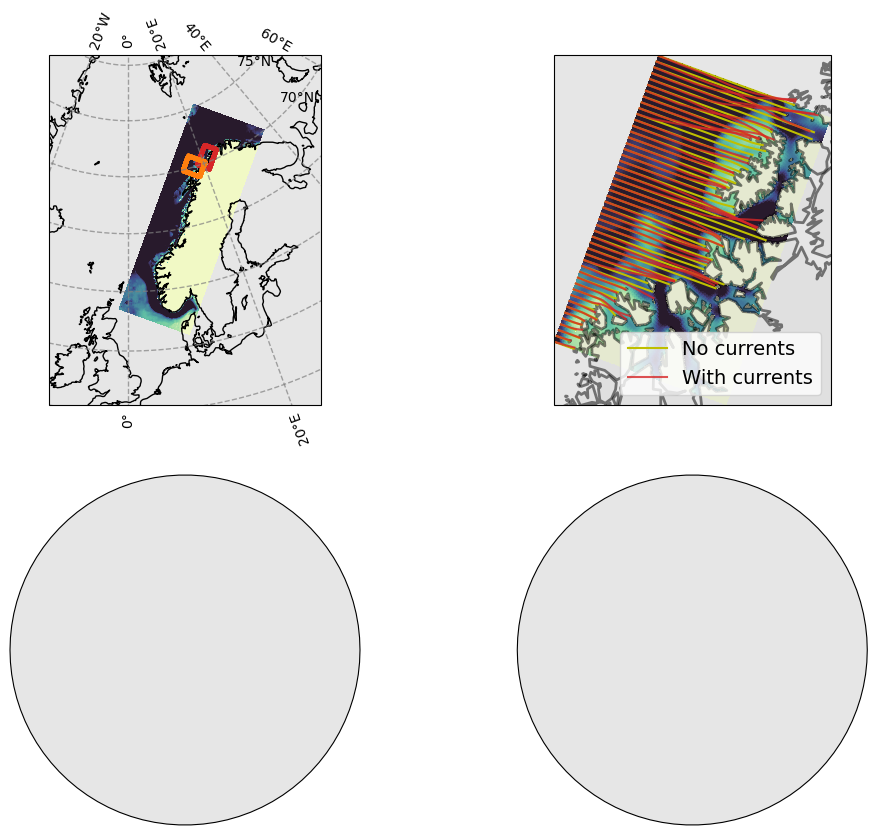

In [63]:
fs=14
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(12,10),frameon=False,subplot_kw=crs_kws)
 

pc=ax[0,0].pcolormesh(da.lon,da.lat,-da.h,shading='auto',cmap=cmocean.cm.deep_r,
                         vmin=-200,vmax=0, transform=data_crs)
pc1=ax[0,1].pcolormesh(ocn_subset.lon,ocn_subset.lat,-wt_ocn.d,shading='auto',cmap=cmocean.cm.deep_r,
                         vmin=-200,vmax=0, transform=data_crs)


ax[0,0].plot(subset_lon_extent, subset_lat_extent,marker='o',ms=2,linestyle='None',c='tab:red',
           label='Subset domain',transform=data_crs)

ax[0,0].plot(subset_lon_extent_mosk, subset_lat_extent_mosk,marker='o',ms=2,linestyle='None',c='tab:orange',
           label='Subset domain',transform=data_crs)

step=1
for i in range(0,wt_zero.nb_wave_rays,step):
    if i ==0:        
        ax[0,1].plot(ds_zero.ray_lon[i,:],ds_zero.ray_lat[i,:],c='y',lw=1.5, alpha=1,label='No currents',transform=data_crs)
    else:
        ax[0,1].plot(ds_zero.ray_lon[i,:],ds_zero.ray_lat[i,:],c='y',lw=1.5,alpha=1,transform=data_crs)

for i in range(0,wt_ocn.nb_wave_rays,step):
    if i == 0:
        ax[0,1].plot(ds_ocn.ray_lon[i,:],ds_ocn.ray_lat[i,:],c='tab:red',lw=1.5,alpha=0.8,label='With currents',transform=data_crs)        
    else:
        ax[0,1].plot(ds_ocn.ray_lon[i,:],ds_ocn.ray_lat[i,:],c='tab:red',lw=1.5,alpha=0.8,transform=data_crs)


ax[0,1].legend(fontsize=fs,loc='lower right')
ax[0,0].coastlines()
#ax[1].coastlines()
ax[0,0].set_extent([-10,25,50,80],geodetic)

#ax.set_extent(plot_extent, geodetic)
ax[0,1].add_geometries(
        f.intersecting_geometries([lonmin, lonmax, latmin-.1, latmax]),
        ccrs.PlateCarree(),
        facecolor=cfeature.COLORS['land_alt1'],
        edgecolor='black',alpha=0.5,linewidth=2)


gl = ax[0,0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1., color='gray', alpha=0.7, linestyle='--')

ax[0,0].tick_params(labelsize=fs)


pc2=ax[1,0].pcolormesh(ocn_subset_mosken.lon, ocn_subset_mosken.lat, speed_OT[:,:],
                           cmap=cmocean.cm.speed, vmax=2, transform=data_crs)

jump2=2
ax[1,0].quiver(ocn_subset_mosken.lon.data[::jump2,::jump2], 
            ocn_subset_mosken.lat.data[::jump2,::jump2], 
            ocn_subset_mosken.u_eastward.isel(time=0).data[::jump2,::jump2], 
            ocn_subset_mosken.v_northward.isel(time=0).data[::jump2,::jump2],
            width=0.005, scale=25, color='k',pivot='mid', transform=data_crs, 
            target_extent=plot_extent,alpha=1)



pc3=ax[1,1].pcolormesh(ocn_subset_mosken.lon, ocn_subset_mosken.lat, speed_IT[:,:],
                           cmap=cmocean.cm.speed, vmax=2, transform=data_crs)
ax[1,1].quiver(ocn_subset_mosken.lon.data[::jump2,::jump2], 
            ocn_subset_mosken.lat.data[::jump2,::jump2], 
            ocn_subset_mosken.u_eastward.isel(time=1).data[::jump2,::jump2], 
            ocn_subset_mosken.v_northward.isel(time=1).data[::jump2,::jump2],
            width=0.005, scale=25, color='k',pivot='mid', transform=data_crs, 
            target_extent=plot_extent,alpha=1)

for i in range(0,wt_mosk_IT.nb_wave_rays,1):
    ax[1,0].plot(ds_mosk_OT.ray_lon[i,:],ds_mosk_OT.ray_lat[i,:],'-',c='tab:red',transform=ccrs.PlateCarree(),alpha=1,lw=1)
    ax[1,1].plot(ds_mosk_IT.ray_lon[i,:],ds_mosk_IT.ray_lat[i,:],'-',c='tab:red',
                 alpha=0.7,transform=ccrs.PlateCarree(),lw=1)



for aax in [ax[1,0],ax[1,1]]:

    aax.set_extent([12.5, 13.1, 67.6, 67.95], geodetic)
    aax.add_geometries(
            f.intersecting_geometries(plot_extent),
            ccrs.PlateCarree(),
            facecolor=cfeature.COLORS['land_alt1'],
            edgecolor='black',alpha=0.5,linewidth=2)


fig.tight_layout()

cb = fig.colorbar(pc,ax=[ax[0,0],ax[0,1]],shrink=0.8,pad=0.04,extend='min',orientation='vertical')
cb.set_label('Depth [m]',fontsize=fs)

cb2 = fig.colorbar(pc2,ax=[ax[1,0],ax[1,1]],shrink=0.8,pad=0.04,extend='max',orientation='vertical')
cb2.set_label('Speed [m/s]',fontsize=fs)

for ccb in [cb,cb2]:
    ccb.ax.tick_params(labelsize=fs-2) 

#fig.savefig(fname='ocean_model_example.png', dpi=130,transparent=False)


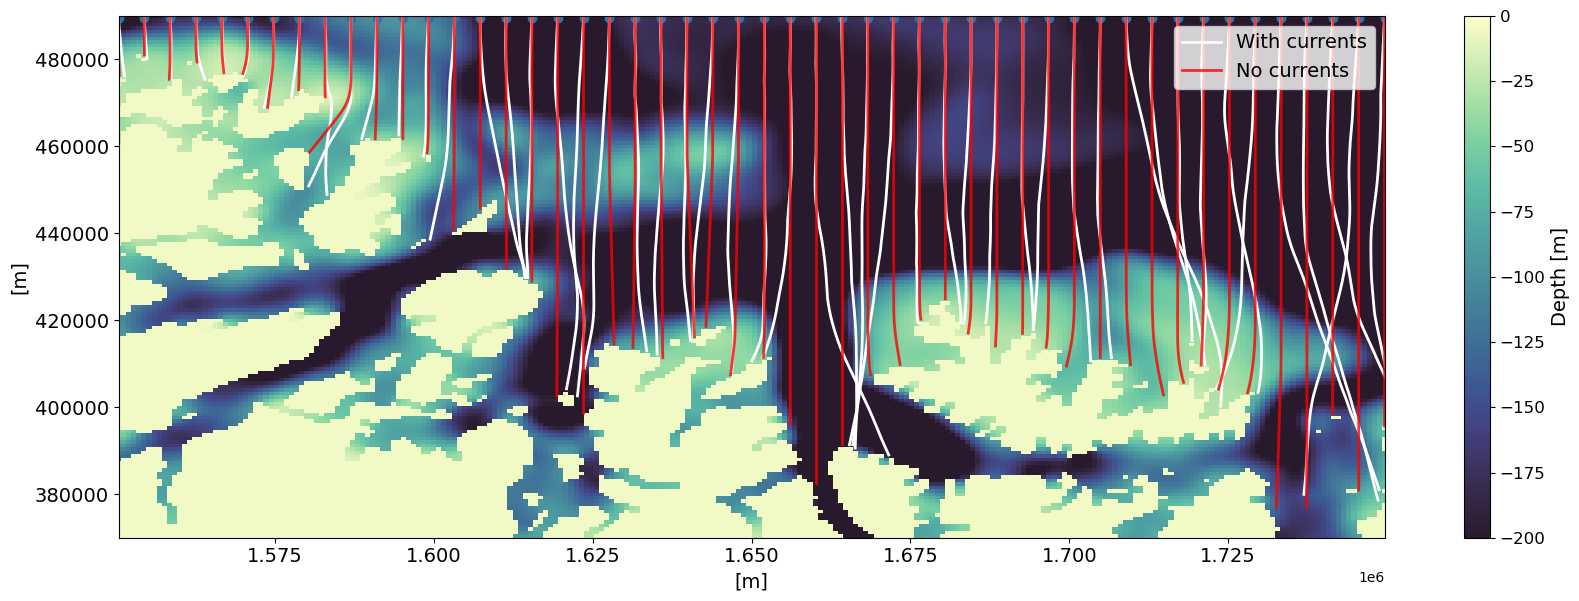

In [64]:
fs=14
fig,ax = plt.subplots(figsize=(17,6))
 
pc=ax.pcolormesh(wt_ocn.x,wt_ocn.y,-wt_ocn.d,shading='auto',cmap=cmocean.cm.deep_r,
                         vmin=-200,vmax=0)

    

ax.plot(wt_ocn.ray_x[:,0],wt_ocn.ray_y[:,0],'o')
step=1
for i in range(0,wt_ocn.nb_wave_rays,step):
    if i == 0:
        ax.plot(ds_ocn.ray_x[i,:],ds_ocn.ray_y[i,:],'-w',lw=2,alpha=1,label='With currents')        
    else:
        ax.plot(ds_ocn.ray_x[i,:],ds_ocn.ray_y[i,:],'-w',lw=2,alpha=1)
    
for i in range(0,wt_zero.nb_wave_rays,step):
    if i ==0:        
        ax.plot(ds_zero.ray_x[i,:],ds_zero.ray_y[i,:],'r',lw=2, alpha=0.8,label='No currents')
    else:
        ax.plot(ds_zero.ray_x[i,:],ds_zero.ray_y[i,:],c='r',lw=2,alpha=.8)

ax.set_xlim([wt_ocn.domain_X0,wt_ocn.domain_XN])

ax.set_xlabel('[m]',fontsize=fs)
ax.set_ylabel('[m]',fontsize=fs)

ax.legend(fontsize=fs,loc='upper right')

fig.tight_layout()

cb = fig.colorbar(pc)
cb.set_label('Depth [m]',fontsize=fs)

cb.ax.tick_params(labelsize=fs-2) 

ax.tick_params(labelsize=fs)